Total number of observations: 434
Low incone                  : 232
Medium income               : 158
High income                 : 44


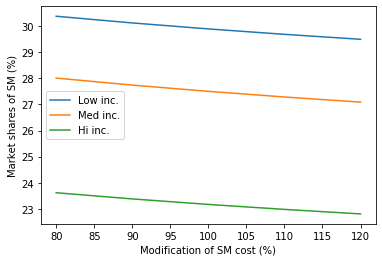

In [2]:
# Michel Bierlaire
# Wed Oct 31 18:48:52 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.models import logit
from biogeme.expressions import Beta, DefineVariable, log
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("telephone.dat",'\t')
database = db.Database("telephone",df)
pd.options.display.float_format = '{:.3g}'.format
globals().update(database.variables)

#Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
ASC_BM	 = Beta('ASC_BM',0,None,None,0)
ASC_SM	 = Beta('ASC_SM',0,None,None,1)
ASC_LF	 = Beta('ASC_LF',0,None,None,0)
ASC_EF	 = Beta('ASC_EF',0,None,None,0)
ASC_MF	 = Beta('ASC_MF',0,None,None,0)
B_FCOST	 = Beta('B_FCOST',0,None,None,0)
B_MCOST	 = Beta('B_MCOST',0,None,None,0)
B_USERS	 = Beta('B_USERS',0,None,None,0)

# Define here arithmetic expressions for name that are not directly
# available from the data

logcostBM  = DefineVariable('logcostBM', log(cost1),database)
logcostSM  = DefineVariable('logcostSM', log(cost2),database)
logcostLF  = DefineVariable('logcostLF', log(cost3),database)
logcostEF  = DefineVariable('logcostEF', log(cost4),database)
logcostMF  = DefineVariable('logcostMF', log(cost5),database)

#Utilities
V_BM = ASC_BM + B_MCOST * logcostBM
V_SM = ASC_SM + B_MCOST * logcostSM
V_LF = ASC_LF + B_FCOST * logcostLF + B_USERS * users
V_EF = ASC_EF + B_FCOST * logcostEF + B_USERS * users
V_MF = ASC_MF + B_FCOST * logcostMF + B_USERS * users

V = {1: V_BM, 2: V_SM, 3: V_LF, 4: V_EF, 5: V_MF}
avail = {1: avail1, 2: avail2, 3: avail3, 4: avail4, 5: avail5}

# The choice model is a logit, with availability conditions
logprob = models.loglogit(V,avail,choice)
biogeme  = bio.BIOGEME(database,logprob)
biogeme.modelName = "logit_Tel_socioec"
results = biogeme.estimate()

# Duplicate the database
database_lowInc = db.Database("telephone_lowInc",pd.DataFrame.copy(database.data))
database_medInc = db.Database("telephone_medInc",pd.DataFrame.copy(database.data))
database_highInc = db.Database("telephone_highInc",pd.DataFrame.copy(database.data))

# Remove observations
database_lowInc.remove(inc > 2)
database_medInc.remove(((inc < 3)+(inc > 4))>0)
database_highInc.remove(inc < 5)
print(f"Total number of observations: {database.getNumberOfObservations()}")
print(f"Low incone                  : {database_lowInc.getNumberOfObservations()}")
print(f"Medium income               : {database_medInc.getNumberOfObservations()}")
print(f"High income                 : {database_highInc.getNumberOfObservations()}")

# Function that calculates the market shares for SM for a given scaling of the cost

def scenario(costScale,database):
    V_BM = ASC_BM + B_MCOST * log(costScale * cost1)
    V_SM = ASC_SM + B_MCOST * log(costScale * cost2)
    V_LF = ASC_LF + B_FCOST * log(costScale * cost3) + B_USERS * users
    V_EF = ASC_EF + B_FCOST * log(costScale * cost4) + B_USERS * users
    V_MF = ASC_MF + B_FCOST * log(costScale * cost5) + B_USERS * users
    V = {1: V_BM, 2: V_SM, 3: V_LF, 4: V_EF, 5: V_MF}
 
    ##### Aggregate marketshares

    prob_SM = logit(V,avail,2)
    simulate = {'Prob. SM': prob_SM}
    biosim  = bio.BIOGEME(database,simulate)
    biosim.modelName = f"marketShares_SM_{costScale}"
    simresults = biosim.simulate(dict(zip(results.data.betaNames, results.data.betaValues)))
    return 100*simresults['Prob. SM'].mean()

#scales = np.arange(0.1,2.1,0.1)
scales = np.arange(0.8,1.3,0.1)
shares_low = [scenario(s,database_lowInc) for s in scales]
shares_med = [scenario(s,database_medInc) for s in scales]
shares_hi = [scenario(s,database_highInc) for s in scales]

fig, ax = plt.subplots()
ax.plot(100*scales,shares_low,label='Low inc.')
ax.plot(100*scales,shares_med,label='Med inc.')
ax.plot(100*scales,shares_hi,label='Hi inc.')
ax.legend()
plt.xlabel("Modification of SM cost (%)")
plt.ylabel("Market shares of SM (%)")
plt.show()
